In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-dateset/flickr30k_images/results.csv
/kaggle/input/image-dateset/flickr30k_images/.ipynb_checkpoints/results-checkpoint.csv
/kaggle/input/image-dateset/flickr30k_images/images/2715746315.jpg
/kaggle/input/image-dateset/flickr30k_images/images/3463034205.jpg
/kaggle/input/image-dateset/flickr30k_images/images/268704620.jpg
/kaggle/input/image-dateset/flickr30k_images/images/2673564214.jpg
/kaggle/input/image-dateset/flickr30k_images/images/7535037918.jpg
/kaggle/input/image-dateset/flickr30k_images/images/4912369161.jpg
/kaggle/input/image-dateset/flickr30k_images/images/4828071602.jpg
/kaggle/input/image-dateset/flickr30k_images/images/6802728196.jpg
/kaggle/input/image-dateset/flickr30k_images/images/3346289227.jpg
/kaggle/input/image-dateset/flickr30k_images/images/3217056901.jpg
/kaggle/input/image-dateset/flickr30k_images/images/272471327.jpg
/kaggle/input/image-dateset/flickr30k_images/images/4717261252.jpg
/kaggle/input/image-dateset/flickr30k_images/images/47

In [2]:
!pip install pandas
import pandas as pd
import numpy as np
import tensorflow as tf

  Using cached pandas-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)


2023-11-10 00:56:54.178314: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 00:56:54.185962: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 00:56:54.290028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 00:56:54.290093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 00:56:54.290146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
import os

In [4]:
current_directory = os.getcwd()
current_directory

'/home/kavin/API2'

In [5]:
data_caption=pd.read_csv("/kaggle/input/image-dateset/flickr30k_images/results.csv",delimiter="|")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/image-dateset/flickr30k_images/results.csv'

In [ ]:
data_caption.dropna(inplace=True)

In [6]:
data_caption.drop([' comment_number'],axis=1,inplace=True)

NameError: name 'data_caption' is not defined

In [7]:
from tensorflow.keras.applications import VGG16,DenseNet201

In [8]:

from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

ModuleNotFoundError: No module named 'tqdm'

In [16]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
image_path="/kaggle/input/image-dateset/flickr30k_images/images"
img_size = 224
features = {}
for image in tqdm(os.listdir("/kaggle/input/image-dateset/flickr30k_images/images")):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [54:20<00:00,  9.75it/s]  


In [17]:
caption={}

for image_name in tqdm(os.listdir("/kaggle/input/image-dateset/flickr30k_images/images")):
    contains_string = data_caption['image_name'].str.contains(image_name)
    rows_with_string = data_caption[contains_string]
    caption[image_name]=rows_with_string[' comment'].tolist()
    

100%|██████████| 31783/31783 [45:49<00:00, 11.56it/s]


In [20]:
len(caption)==len(features)

True

In [21]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [22]:
clean(caption)

In [23]:
captions=[]
for key in caption:
    for cap in caption[key]:
        captions.append(cap)

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [25]:
image_ids = list(caption.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [26]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [10]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [11]:
feature.shape

NameError: name 'feature' is not defined

In [14]:
# encoder model
# image feature layers
inputs1 = Input(shape=((1,1920)))  # Modify the input shape to match DenseNet-201 features
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


NameError: name 'vocab_size' is not defined

In [30]:
from tensorflow.keras.utils import to_categorical

In [117]:
# train the model
epochs = 20
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, caption,features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



1787/1787 [==============================] - 453s 253ms/step - loss: 2.6741


In [118]:
model.save("newmodel_20epochs.h5")

In [119]:
def index_to_word(Integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==Integer:
            return word
    return None

In [120]:
def Predict_cap(model,image,tokenizer,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],max_length)
        yhat=model.predict([image,sequence],verbose=0)
        yhat=np.argmax(yhat)
        word=index_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text+=" "+word
        
        if word=='endseq':
            break
    return in_text

In [121]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    img_path=os.path.join("/kaggle/input/image-dateset/flickr30k_images/images",image_name)
    image=Image.open(img_path)
    ypred=Predict_cap(model,features[image_name].reshape((1,1,1920)),tokenizer,max_length)
    print(ypred)
    plt.imshow(image)

In [122]:
features['2421801040.jpg'].shape

(1, 1920)

In [123]:
import random

startseq dog runs through the grass endseq


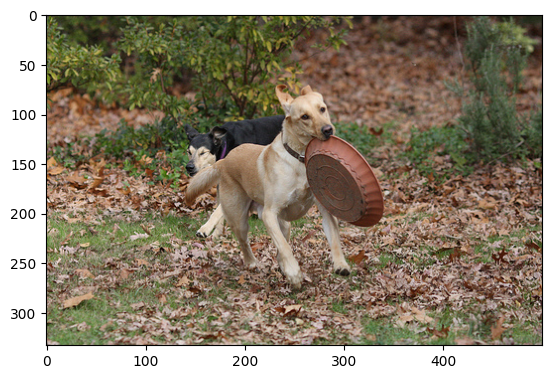

In [148]:
generate_caption(str(random.choice(test)))